# Kernel-based Time-varying Regression - Part III

In previous tutorials, we covered the model fitting, validation and visualization of regression and seasonal models. We will cover a few more configurations here for advanced users.

In summary, we will cover advance configurations on

1. different ways to specify knots position
2. regressions
- regressors signs
- adjusting knot sensitivity with respect to volume of response
3. time-point priors for coefficients

In [13]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.plot import get_orbit_style
from orbit.utils.dataset import load_iclaims

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
print(orbit.__version__)

1.0.16dev


## Fitting with iClaims Data

Let's use a weekly iclaims data here.

In [ ]:
# without the endate, we would get end date='2018-06-24' to make our tutorial consistent with the older version
df = load_iclaims(end_date='2020-11-29')

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)
df.head()

(570, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.03493,-0.34414,0.12802,-0.53745,0.08456
1,2010-01-10,13.62422,0.03493,-0.22053,0.17932,-0.54529,0.07235
2,2010-01-17,13.39874,0.05119,-0.31817,0.12802,-0.58504,0.49424
3,2010-01-24,13.13755,0.01840,-0.22053,0.11744,-0.60156,0.39055
4,2010-01-31,13.19676,-0.05059,-0.26816,0.08501,-0.60874,0.44931


There are flexible ways to control the number of knots in the model. We will go through the following one by one:

- `level_segements`
- `level_knot_distance`
- `level_knot_dates`

### Specifying Levels Segments

In the case of providing `level_segements`, we impose an implicit rule of putting knots on the edge of each segment meaning the total number of knots would be the number of segments plus one. To illustrate that, let's try `level_segments=10`

In [ ]:
response_col = 'claims'
date_col='week'

In [21]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,

    level_segments=10,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi'
)

INFO:root:Guessed max_plate_nesting = 1


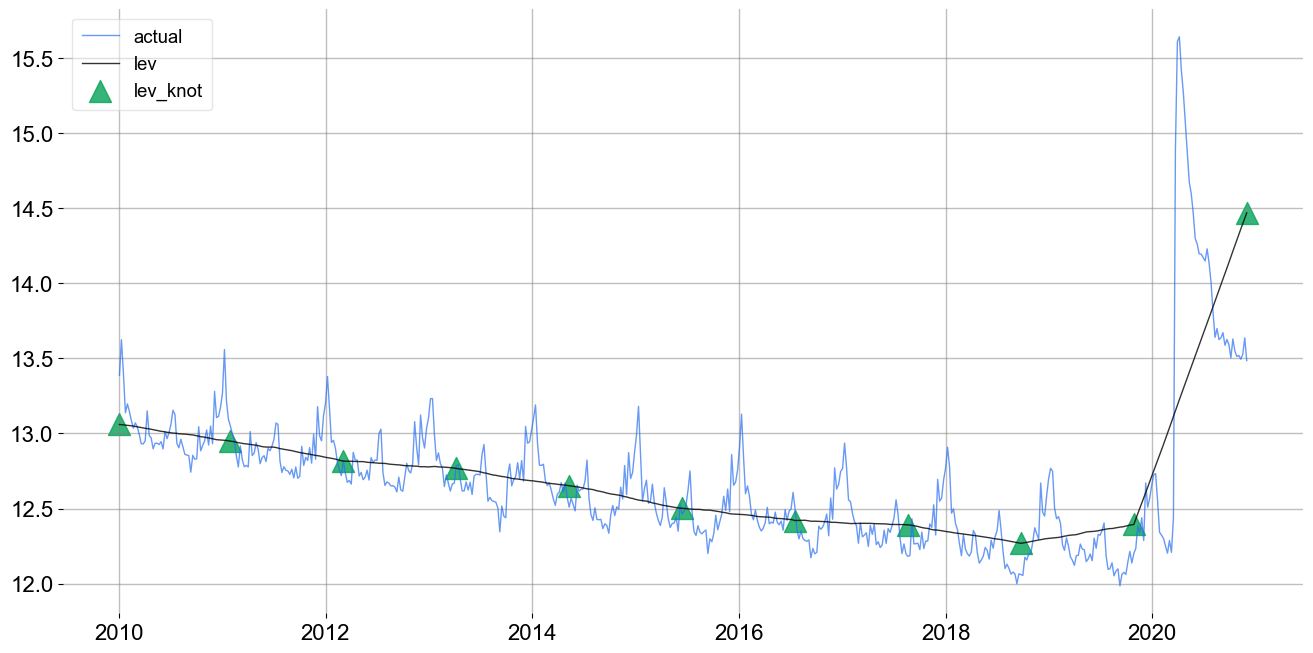

In [22]:
ktr.fit(df=df)
_ = ktr.plot_lev_knots()

You should see precisely there are $11$ knots evenly distributed in above chart.

### Specifying Knots Distance

In the case of providing `level_knot_distance`, we are imposing the knots distance directly along with the additional knots at the beginning and the end of the series. For example, in a weekly data, by putting `level_knot_distance=104` roughly means putting a knot once in two years.

In [26]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    level_knot_distance=104,
    
    # fit a weekly seasonality
    seasonality=52,
    # high order for sharp turns on each week
    seasonality_fs_order=12,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi'
)

INFO:root:Guessed max_plate_nesting = 1


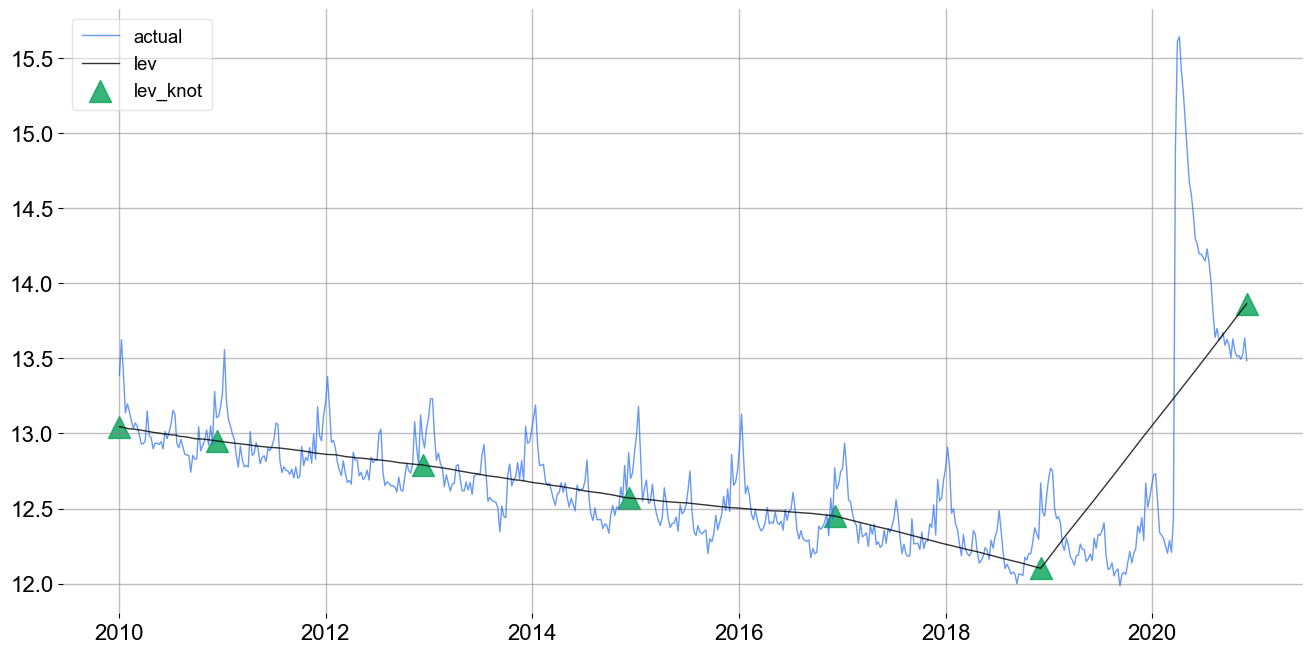

In [27]:
ktr.fit(df=df)
_ = ktr.plot_lev_knots()

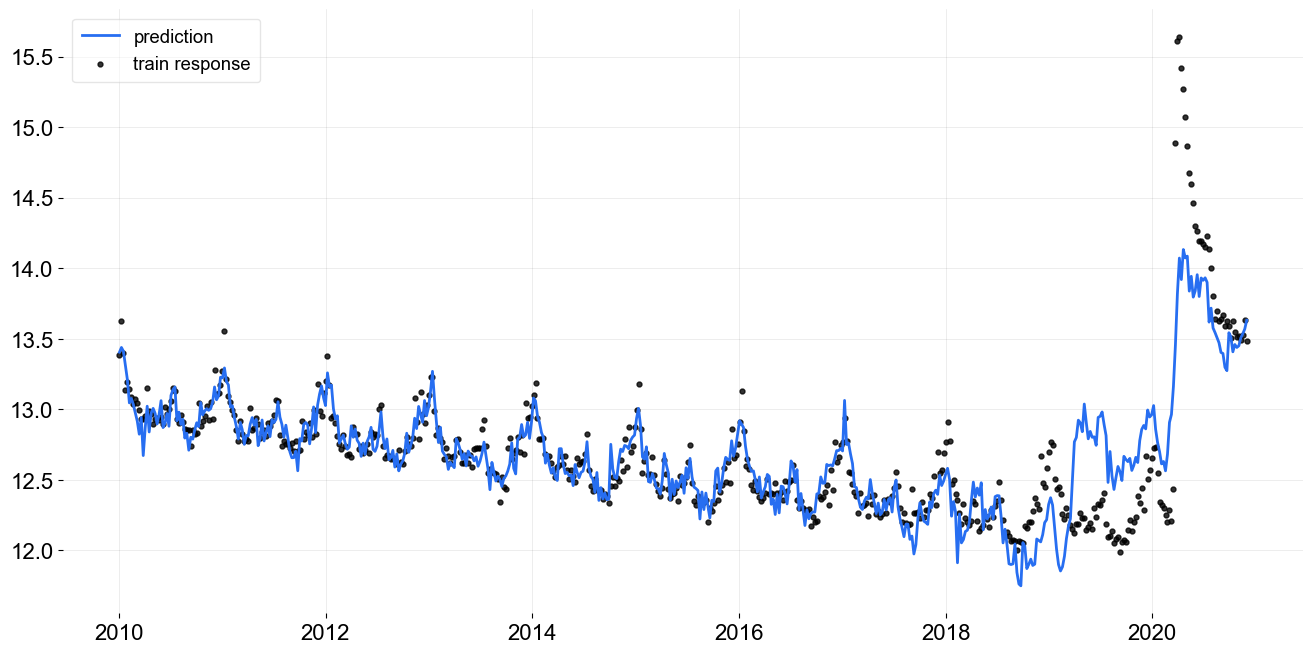

In [28]:
predicted_df = ktr.predict(df=df)
_ = plot_predicted_data(training_actual_df=df, predicted_df=predicted_df, 
                        date_col=date_col, actual_col=response_col)

In [ ]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    level_knot_distance=104,
    
    # fit a weekly seasonality
    seasonality=52,
    # high order for sharp turns on each week
    seasonality_fs_order=12,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi'
)

In [45]:
df.tail()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
565,2020-11-01,13.51967,1.64218,0.12879,-0.29642,0.58262,0.40025
566,2020-11-08,13.49442,1.84697,0.16725,-0.11410,0.60397,0.32682
567,2020-11-15,13.52695,1.80923,0.34010,-0.20111,0.59624,0.35246
568,2020-11-22,13.63628,1.77001,0.80213,-0.40178,0.61870,0.22386
569,2020-11-29,13.48495,1.88334,0.06816,-0.20111,0.63526,0.22146


In [49]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    level_knot_dates =  ['2010-01-03', '2020-03-15', '2020-03-22', '2020-11-29'],
    
    # fit a weekly seasonality
    seasonality=52,
    # high order for sharp turns on each week
    seasonality_fs_order=12,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi'
)


In [ ]:
ktr.fit(df=df)



INFO:root:Guessed max_plate_nesting = 1


In [52]:
predicted_df = ktr.predict(df=df)
_ = plot_predicted_data(training_actual_df=df, predicted_df=predicted_df, prediction_percentiles=[2.5, 97.5],
                        date_col=date_col, actual_col=response_col)

,week,prediction_2.5,prediction,prediction_97.5
0,2010-01-03,12.22567,13.35097,14.24553
1,2010-01-10,12.55908,13.36110,14.23806
2,2010-01-17,12.50817,13.35443,14.65402
3,2010-01-24,12.62143,13.23130,14.11024
4,2010-01-31,12.18555,13.11840,14.19325
...,...,...,...,...
565,2020-11-01,12.68533,13.66659,14.72770
566,2020-11-08,12.73812,13.71805,14.80608
567,2020-11-15,12.63152,13.81004,14.65819
568,2020-11-22,12.84906,13.90334,15.03901
